# Data Loading: LMDB Database

## Overview

This example shows you how to use the data that is stored in LMDB database, in Caffe and Caffe 2 formats, with DALI.

## Caffe LMDB Format

To use data that is stored in LMDB in the Caffe format, we need to use the `readers.caffe` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, the operator takes `path` argument, which is the path to the directory where LMDB is stored.

1. We need to define a simple pipeline that takes images that are stored in the Caffe format, decodes them, and prepares them for ingestion in DL framework.

Processing the images involves cropping, normalizing, and completing the `HWC` -> `CHW` conversion process.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to the installed version of DALI.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import os.path

test_data_root = os.environ["DALI_EXTRA_PATH"]
db_folder = os.path.join(test_data_root, "db", "lmdb")
batch_size = 9

pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    jpegs, labels = fn.readers.caffe(path=db_folder)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    output = fn.crop_mirror_normalize(
        images,
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        crop_pos_x=fn.random.uniform(range=(0, 1)),
        crop_pos_y=fn.random.uniform(range=(0, 1)),
    )
    pipe.set_outputs(output, labels)

2. Build and run the pipeline:

In [2]:
pipe.build()
pipe_out = pipe.run()

3. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
4. For the visualization purposes, transpose the images back to the `HWC` layout.

In [3]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch):
    columns = 3
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize=(20, (20 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1, 2, 0)) / 255.0
        plt.imshow(img_hwc)

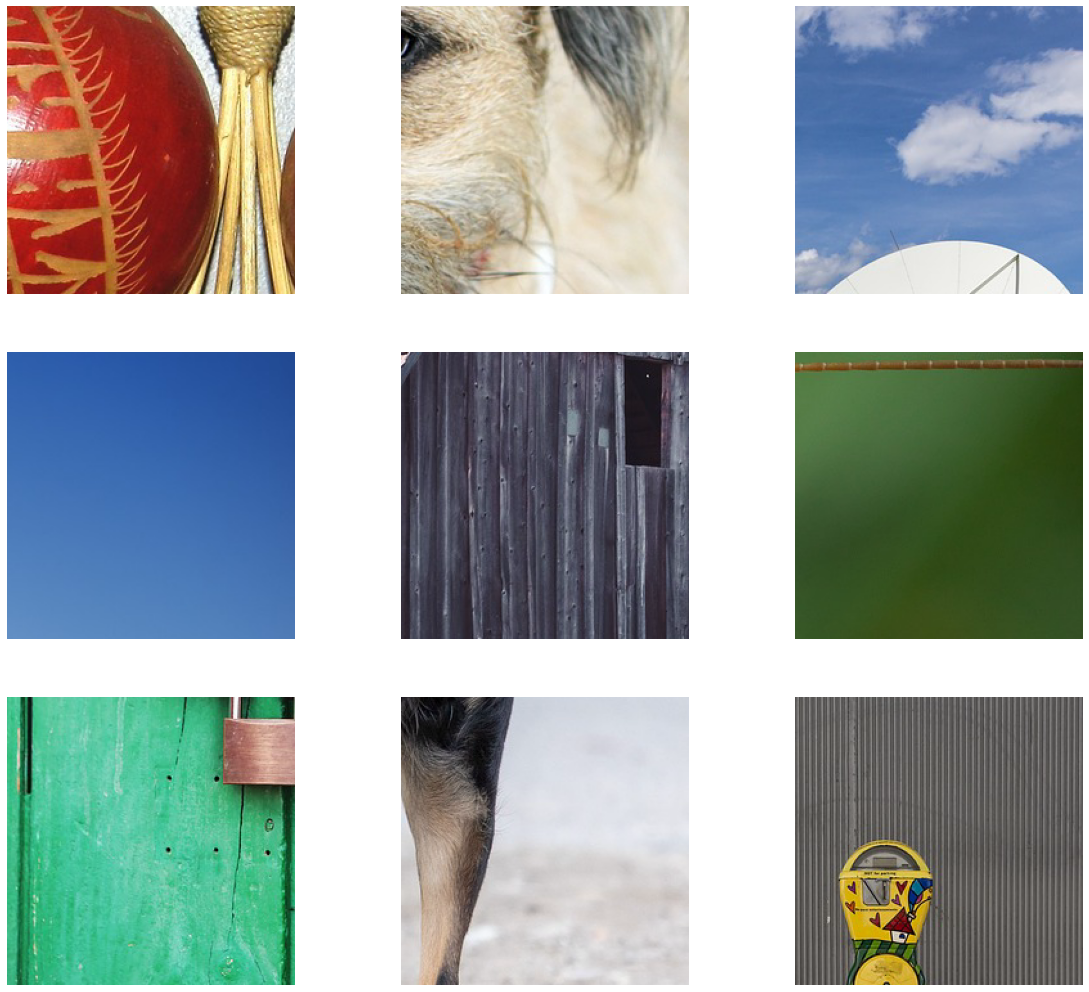

In [4]:
images, labels = pipe_out
show_images(images.as_cpu())

## Caffe 2 LMDB Format

To use the data that is stored in LMDB in the Caffe 2 format, we need to use the `readers.caffe2` operator. Like the `readers.caffe` operator, in addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes the `path` argument, which is the path to the directory where LMDB is stored.

1. Define a simple pipeline that loads images that are stored in the Caffe 2 format, decodes them and prepares them for ingestion in DL framework. 

   Processing the images involves cropping, normalizing, and completing the `HWC` -> `CHW` conversion process.

In [5]:
db_folder = os.path.join(test_data_root, "db", "c2lmdb")

pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    jpegs, labels = fn.readers.caffe2(path=db_folder)
    images = fn.decoders.image(jpegs, device="mixed", output_type=types.RGB)
    output = fn.crop_mirror_normalize(
        images,
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    )
    pipe.set_outputs(output, labels)

2. Let us now build and run the pipeline:

In [6]:
pipe.build()
pipe_out = pipe.run()

3. To visualize the results, you can use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
4. For the visualization purposes, transpose the images back to the `HWC` layout.

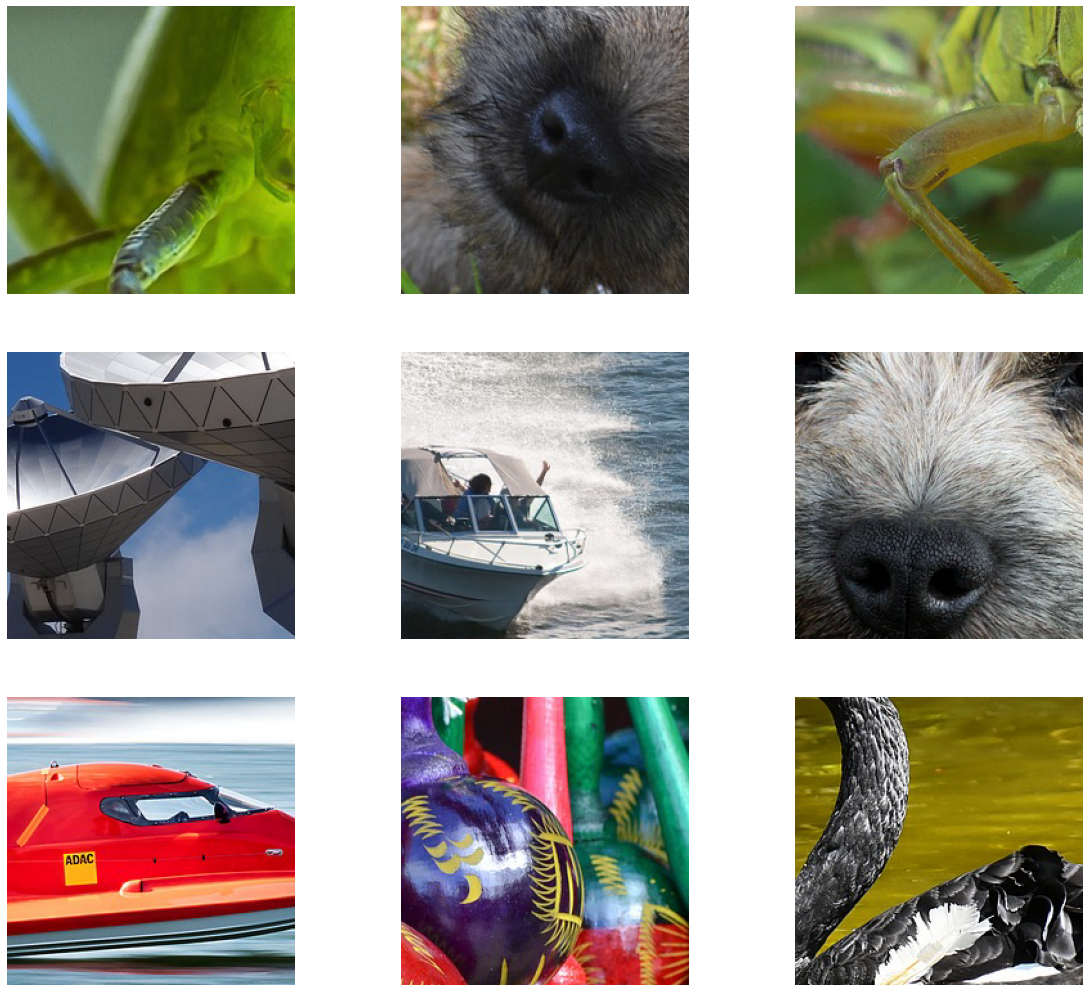

In [7]:
images, labels = pipe_out
show_images(images.as_cpu())